In [1]:
import sys
sys.path.append('../code')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
import read_video as rv
import reconstruction_utils as ru

In [4]:
import reconstruction as rec

In [5]:
#filepath = 'F:/LiverCells/Holo_mod_5fpsEvery1_6/Holo_mod_5fpsEvery1_6_holo.avi'

#filepath = 'F:/CellsLNPs/CellLNPs2hIncubation_t1_Every1_3/CellLNPs2hIncubation_t1_Every1_3_holo.avi'

filepath = 'F:/PSLinOil/PSL450nmOnGlassInImmersionOil_thickLFAF_severalSteps_Every1_2/PSL450nmOnGlassInImmersionOil_thickLFAF_severalSteps_Every1_2_holo.avi'

In [6]:
data = rv.read_video(filepath, 0, 50)

In [7]:
data.shape

(50, 1450, 1930)

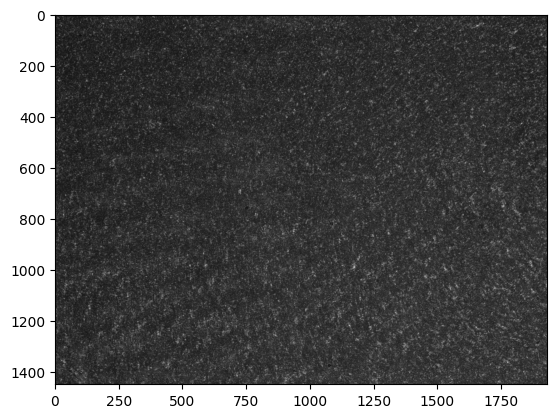

In [8]:
plt.imshow(data[0], cmap='gray')

In [9]:
frame = data[0]

In [20]:
co = rec.HolographicReconstruction()
co.first_image = torch.tensor(frame)
co.mask_radiis = [50, 10]
co.lowpass_filtered_phase = None
co.crop=0
co.phase_corrections = 2

In [21]:
co.precalculations()

In [22]:
data = torch.tensor(data).to('cuda')

C:\Users\Fredrik\AppData\Local\Temp\ipykernel_23260\3855621883.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to('cuda')


In [23]:
datan = co.forward(data)

Reconstructing 50 holograms.


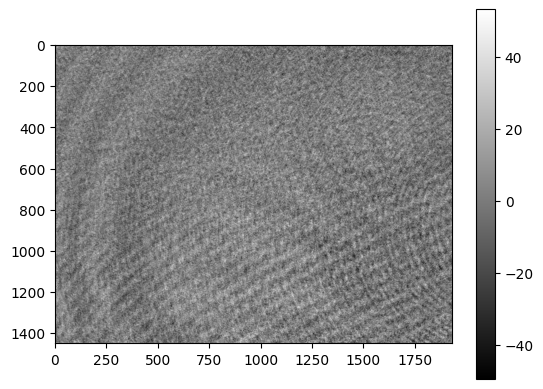

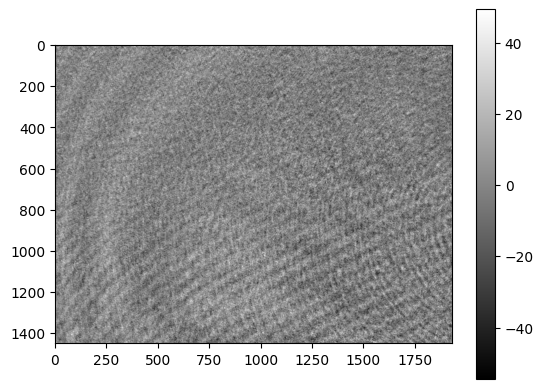

In [24]:
plt.imshow(co.first_field.real.cpu().numpy(), cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(co.first_field_corrected.imag.cpu().numpy(), cmap='gray')
plt.colorbar()

In [25]:
#plt.figure()
#plt.imshow(co.phase_background.real.cpu().numpy(), cmap='gray')
#plt.colorbar()

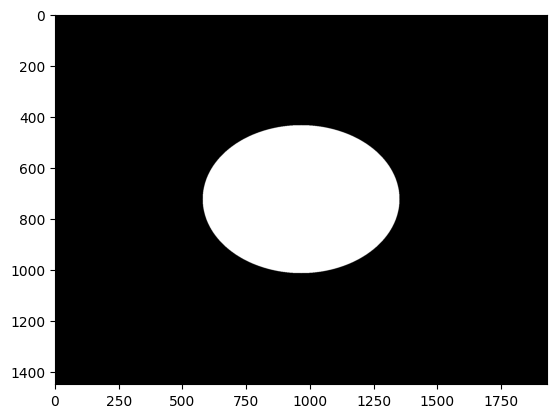

In [26]:
plt.imshow(co.mask_list[0].cpu().numpy(), cmap='gray')

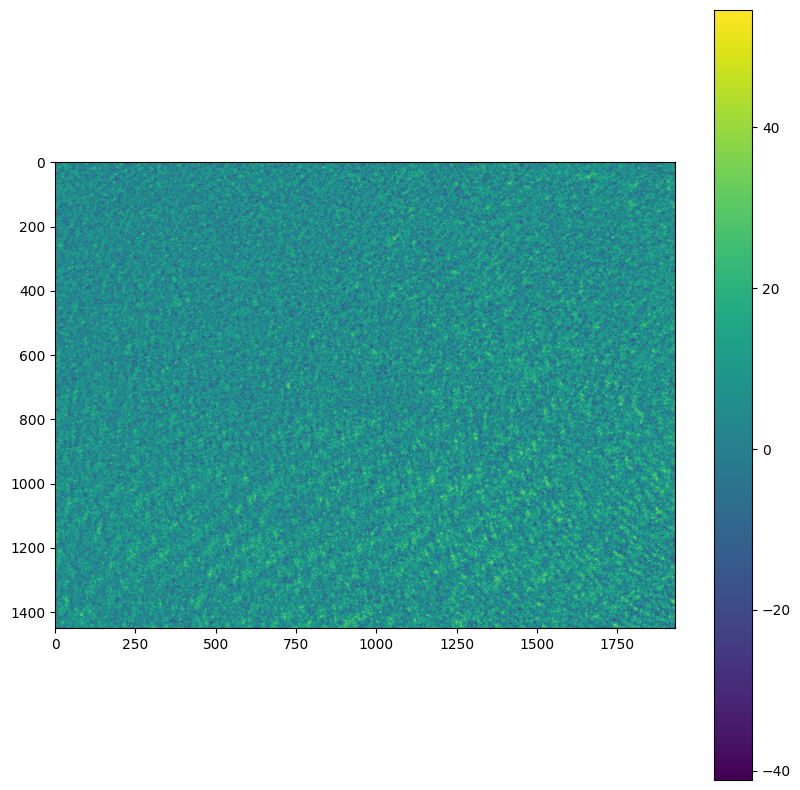

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(datan[10].real.cpu().numpy())
plt.colorbar()

In [28]:
len(co.mask_list)

3

c:\Users\Fredrik\miniconda3\envs\torchenv\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


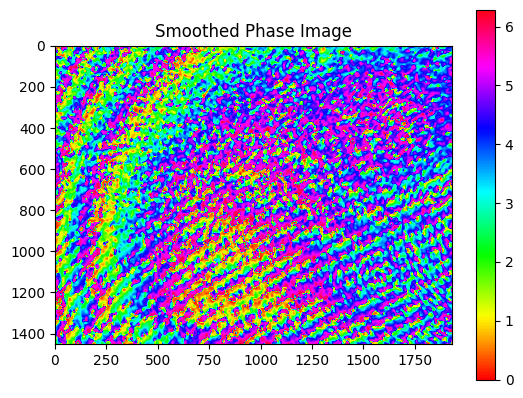

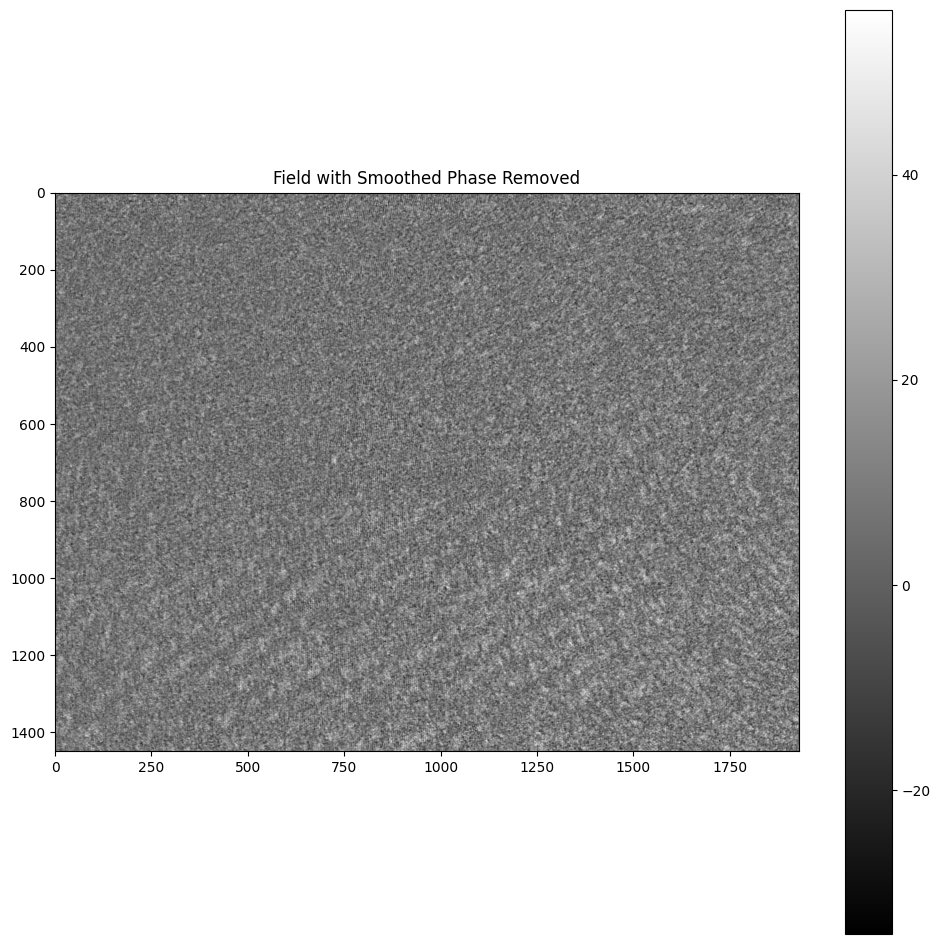

In [29]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


def gaussian_kernel(size: int, sigma: float) -> torch.Tensor:
    """Function to create a Gaussian kernel."""
    coords = torch.arange(size) - size // 2
    x, y = torch.meshgrid(coords, coords)
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel



# Convert phase to complex representation
complex_tensor = co.first_field.unsqueeze(0).to('cpu')

# Define a Gaussian kernel
kernel_size = 21  # Adjust for more/less smoothing
sigma = 5.0
kernel = gaussian_kernel(kernel_size, sigma).view(1, 1, kernel_size, kernel_size)

# Calculate padding
padding = (kernel_size - 1) // 2

# Separate real and imaginary parts
real_part = complex_tensor.real
imag_part = complex_tensor.imag

# Apply Gaussian smoothing
real_smoothed = F.conv2d(real_part.unsqueeze(1), kernel, padding=padding)
imag_smoothed = F.conv2d(imag_part.unsqueeze(1), kernel, padding=padding)

# Combine the smoothed real and imaginary parts
smoothed_complex = torch.complex(real_smoothed.squeeze(1), imag_smoothed.squeeze(1))


# Convert back to phase
smoothed_phase = torch.angle(smoothed_complex)

# Normalize phase to [0, 2π]
smoothed_phase = (smoothed_phase + 2 * np.pi) % (2 * np.pi)

# Display the smoothed phase image
plt.imshow(smoothed_phase.squeeze(), cmap='hsv')
plt.colorbar()
plt.title('Smoothed Phase Image')
plt.show()

# Remove phase background by subtracting the smoothed phase
# Assuming `co.first_field_corrected` contains the original complex field
# For the sake of example, let's create a dummy `co.first_field_corrected` tensor
# Replace this with the actual field in your application
co_first_field_corrected = co.first_field_corrected.cpu()

# Remove the smoothed phase from the original field
field = co_first_field_corrected * torch.exp(-1j * smoothed_phase)

# Display the real part of the corrected field
plt.figure(figsize=(12, 12))
plt.imshow(field.squeeze().real, cmap='gray')
plt.colorbar()
plt.title('Field with Smoothed Phase Removed')
plt.show()

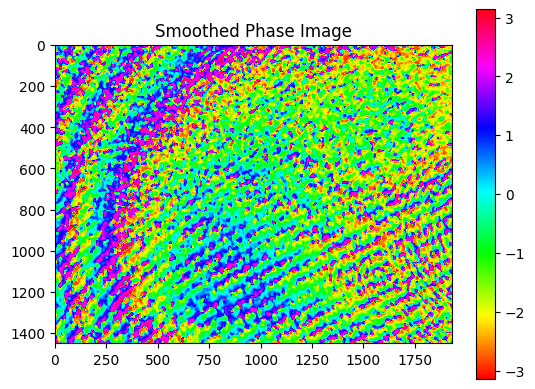

In [30]:
# Display the smoothed phase image
plt.imshow(torch.angle(smoothed_complex).squeeze(), cmap='hsv')
plt.colorbar()
plt.title('Smoothed Phase Image')
plt.show()

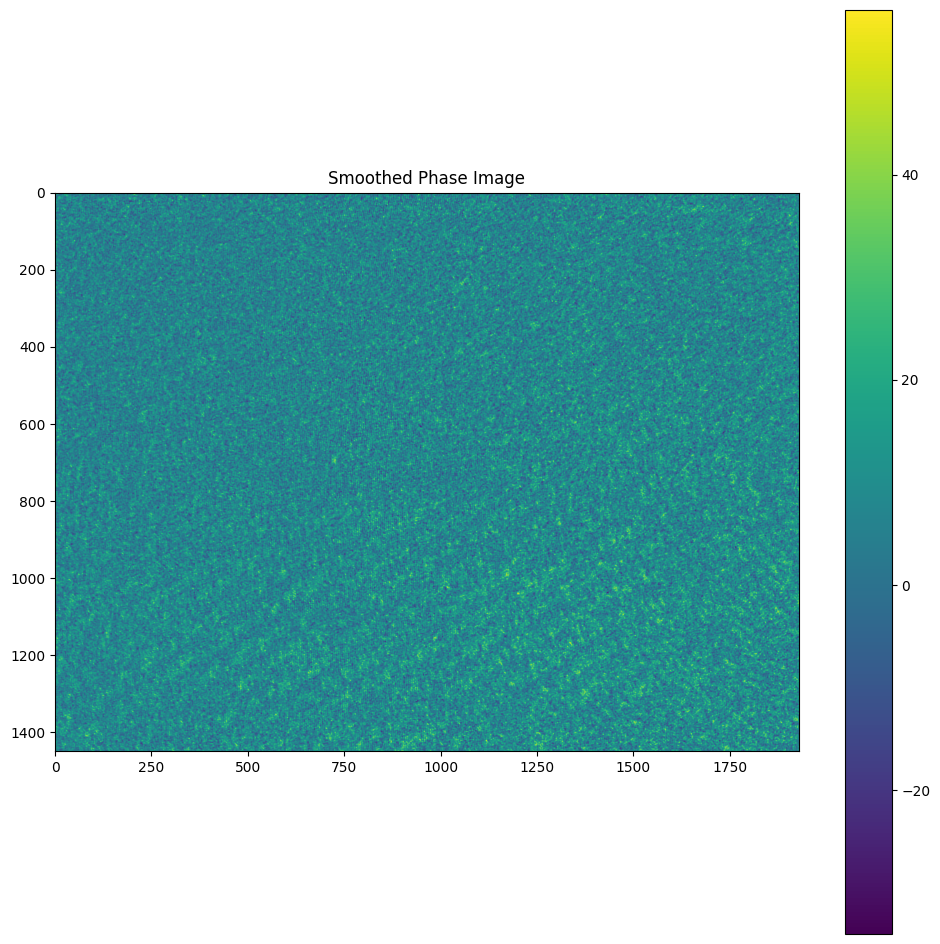

In [31]:
# Display the smoothed phase image
field = co.first_field_corrected.cpu() * torch.exp(-1j*smoothed_phase)

plt.figure(figsize=(12, 12))
plt.imshow(field.squeeze().real)
plt.colorbar()
plt.title('Smoothed Phase Image')
plt.show()